## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

## Import Datasets

In [ ]:
df = pd.read_csv('dataset/train-filtered.tsv', delimiter='\t')
df.head()

## Exploratory Data Analysis (EDA)

### Data information

In [ ]:
df.info()

The dataset used consists of 902 entries.

### Missing data

In [ ]:
df.isnull().sum().sort_values(ascending=False)

There is no null data.

### More data insights

In [ ]:
number = df['LABEL'].value_counts().sort_values(ascending=False)
percent = df['LABEL'].value_counts().sort_values(ascending=False) / len(df) * 100

dataRating = pd.concat([number, percent], axis=1, keys=['Number of Rating','Percent'])
dataRating

In [ ]:
df['LABEL'].value_counts(dropna=False).plot(kind='bar', color='C4')

Insights:
1. Most of the reviews are positive. 557 reviews (61.75 %) are 5 stars.
2. There are 198 reviews (about 22 %) of reviewws are under 3 stars.

In [ ]:
df['LENGTH'] = df['REVIEW'].apply(len)
df.head()

In [ ]:
df[df['LENGTH'] == df['LENGTH'].max()]

In [ ]:
df[df['LENGTH'] == df['LENGTH'].min()]

Insights:
1. The longest review sentences is 1222 characters long, which is very very long for a normal review.
2. The review is quite clean, there is no user bringing just punctuation (, or .) on a review sentence

## Text Cleaning

This text cleaning process includes:
- Upper case handling (so there is no difference in capital letters)
- look for root words in the Indonesian vocabulary (for example, 'membanggakan' == 'bannga' and 'kebanggan' == 'bangga')

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
import re
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

In [ ]:
negative_words = {
    'no', 'not', 'none', 'neither', 'never', 'nobody', 'nothing', 'nowhere',
    "doesn't", "isn't", "wasn't", "shouldn't", "won't", "can't", "couldn't",
    "don't", "haven't", "hasn't", "hadn't", "aren't", "weren't", "wouldn't",
    "daren't", "needn't", "didn't", 'without', 'against', 'negative', 'deny',
    'reject', 'refuse', 'decline', 'unhappy', 'sad', 'miserable', 'hopeless',
    'worthless', 'useless', 'futile', 'disagree', 'oppose', 'contrary',
    'contradict', 'disapprove', 'dissatisfied', 'objection', 'unsatisfactory',
    'unpleasant', 'regret', 'resent', 'lament', 'mourn', 'grieve', 'bemoan',
    'despise', 'loathe', 'detract', 'abhor', 'dread', 'fear', 'worry',
    'anxiety', 'sorrow', 'gloom', 'melancholy', 'dismay', 'disheartened',
    'despair', 'dislike', 'aversion', 'antipathy', 'hate', 'disdain',
    'shouldn', 'off', 'weren', 'hadn', 'all', 'couldn', 'mightn', 'don', 'why',
    'doesn', 'mustn', 'wouldn', 'nor', 'too', 'won', 'didn', 'hasn'
}

stop_words_eng = set(stopwords.words('english'))

In [ ]:
kata_negatif = {
    'namun', 'tidak', 'karena', 'sementara', 'belum', 'telah', 'masih',
    'terhadap', 'secara', 'lain', 'begitu', 'mengapa', 'kenapa', 'daripada', 
    'maka', 'sebelum', 'sesudah', 'sedangkan', 'sementara', 'tetapi', 'kecuali', 
    'selain', 'tanpa', 'agak', 'tapi', 'nggak', 'seharusnya', 'sebetulnya', 'setidaknya', 
    'toh', 'walau', 'tolong', 'tentu', 'amat', 'apalagi', 'bagaimanapun'
}

stop_factory = StopWordRemoverFactory()
stop_words_indo = set(stop_factory.get_stop_words())

In [ ]:
def convert_to_lower(text):
    return text.lower()

def stem_words(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(text)

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords_indo(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in (stop_words_indo - kata_negatif)]
    return " ".join(filtered_tokens)

def remove_stopwords_eng(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in (stop_words_eng - negative_words)]
    return " ".join(filtered_tokens)

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def remove_unimportant_words(text):
    words_to_remove = ['yang', 'yg', 'nya', 'layan', 'tempat', 'makan', 'minum', 'dong', 'eh', 'deh', 'loh', 'kopken', 'excelso', 'gacoan', 'koi', 'gm', 'tp']
    removed = []
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in words_to_remove:
            removed.append(tokens[i])
    return " ".join(removed)

In [ ]:
# Applying the function to the review text
df['PREPROCESS'] = df['REVIEW'].apply(convert_to_lower)
df['PREPROCESS'] = df['PREPROCESS'].apply(stem_words)
df['PREPROCESS'] = df['PREPROCESS'].apply(remove_numbers)
df['PREPROCESS'] = df['PREPROCESS'].apply(remove_punctuation)
df['PREPROCESS'] = df['PREPROCESS'].apply(remove_extra_white_spaces)
df['PREPROCESS'] = df['PREPROCESS'].apply(remove_stopwords_indo)
df['PREPROCESS'] = df['PREPROCESS'].apply(remove_stopwords_eng)
df['PREPROCESS'] = df['PREPROCESS'].apply(remove_unimportant_words)
df.head()

In [ ]:
df['LENGTH_PRE'] = df['PREPROCESS'].apply(len)
df.head()

In [ ]:
df[df['LENGTH_PRE'] == df['LENGTH_PRE'].min()]

In [ ]:
df = df.replace('', np.NaN)
df.isnull().sum()

In [ ]:
df = df.dropna()
df.isnull().sum()

No null data even after the review data is preprocessed

In [ ]:
df.hist(column='LENGTH', by='LABEL', bins=100, figsize=(18,8))

There is no meaningful correlation between review data length and label.

In [ ]:
import warnings
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopword = STOPWORDS

In [ ]:
def wordclouds(a,b):
    all_data = ''.join(a['PREPROCESS'])
    wordcloud = WordCloud(stopwords = stopword, background_color="white").generate(all_data)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(b)
    
def frequency_analysis(data):
    all_data = ''.join(data['PREPROCESS'])
    tokens = nltk.tokenize.word_tokenize(all_data)
    freq_tokens = nltk.FreqDist(tokens)
    print(freq_tokens.most_common())
    
plt.figure(figsize=(20,7))
plt.subplot(231)
one = df[df['LABEL'] == 1]
wordclouds(one,'Rating 1')

plt.subplot(232)
two = df[df['LABEL'] == 2]
wordclouds(two,'Rating 2')

plt.subplot(233)
three = df[df['LABEL'] == 3]
wordclouds(three,'Rating 3')

plt.subplot(234)
four = df[df['LABEL'] == 4]
wordclouds(four,'Rating 4')

plt.subplot(235)
five = df[df['LABEL'] == 5]
wordclouds(five,'Rating 5')

plt.subplot(236)
wordclouds(df,'Train data')

In [ ]:
for i in range (1, 6):
    data_freq = df[df['LABEL'] == i]
    frequency_analysis(data_freq)

In [ ]:
## Checkpoints
df.to_csv('checkpoint/preprocessed-4.csv', index=False)

## Test Data Analysis

In [ ]:
df_test = pd.read_csv('dataset/test-filtered.tsv', delimiter='\t')
df_test.head()

In [ ]:
df_test.info()

In [ ]:
df_test.isnull().sum().sort_values(ascending=False)

In [ ]:
df_test['LENGTH'] = df_test['REVIEW'].apply(len)
df_test.head()

In [ ]:
df_test[df_test['LENGTH'] == df_test['LENGTH'].max()]

In [ ]:
df_test[df_test['LENGTH'] == df_test['LENGTH'].min()]

In [ ]:
# Applying the function to the review text
df_test['PREPROCESS'] = df_test['REVIEW'].apply(convert_to_lower)
df_test['PREPROCESS'] = df_test['PREPROCESS'].apply(stem_words)
df_test['PREPROCESS'] = df_test['PREPROCESS'].apply(remove_numbers)
df_test['PREPROCESS'] = df_test['PREPROCESS'].apply(remove_punctuation)
df_test['PREPROCESS'] = df_test['PREPROCESS'].apply(remove_extra_white_spaces)
df_test['PREPROCESS'] = df_test['PREPROCESS'].apply(remove_stopwords_indo)
df_test['PREPROCESS'] = df_test['PREPROCESS'].apply(remove_stopwords_eng)
df_test['PREPROCESS'] = df_test['PREPROCESS'].apply(remove_unimportant_words)
df_test.head()

In [ ]:
df_test['LENGTH_PRE'] = df_test['PREPROCESS'].apply(len)
df_test.head()

In [ ]:
df_test[df_test['LENGTH_PRE'] == df_test['LENGTH_PRE'].min()]

In [ ]:
df_test = df_test.replace('', np.NaN)
df_test.isnull().sum()

In [ ]:
df_test = df_test.dropna()
df_test.isnull().sum()

In [ ]:
wordclouds(df_test,'Test data wordcloud')

In [ ]:
frequency_analysis(df_test)

In [ ]:
## Checkpoints
df_test.to_csv('checkpoint/test-preprocessed-4.csv', index=False)

## Checkpoints

In [53]:
## Get the checkpoint file
df = pd.read_csv('checkpoint/preprocessed-4.csv')
df_test = pd.read_csv('checkpoint/test-preprocessed-4.csv')

## Data Splitting

In [54]:
from sklearn.model_selection import train_test_split

X = df['PREPROCESS']
Y = df['LABEL']
x_train, x_val, y_train, y_val = train_test_split(X, Y, random_state=42, test_size=0.1)

In [55]:
x_train

643                 cozy buat nongkrong mall antri cepat
168                        pesan dbat tengah jam sendiri
311    salah satu starbucks paling ramah turut sini d...
227    cukup enak saji agak lama mungkin karena volum...
538    nyaman cuma kapasitas kecil top menu greentea ...
                             ...                        
106             mie memang top utama bakso sangat lembut
270                  staff laki tidak ramah bad attitude
860    soto ayam lamongan kuah asa gurih daging ayam ...
435    kemarin belah nona manis lumayan ramai duduk t...
102        baru jam buka puasa nasi habis sedikit kecewa
Name: PREPROCESS, Length: 811, dtype: object

In [56]:
y_train.value_counts()

LABEL
5    500
1    143
4     87
3     44
2     37
Name: count, dtype: int64

In [57]:
x_val

70                                              too much
235                                          nyaman luas
430    oke segi oke spg ramah sopan pokok tidak nyese...
412    pegawai sombong tidak attitude rasa kopi encer...
39                                      cari angin tipis
                             ...                        
139                                          cocok lidah
576                                           siang dulu
424    pesan antar belum buat driver datang resto sup...
425                        bagus staff ramah deket rumah
296                       beberapa macam menu buat sarap
Name: PREPROCESS, Length: 91, dtype: object

In [58]:
y_val.value_counts()

LABEL
5    57
4    14
1    14
2     4
3     2
Name: count, dtype: int64

## Data Modeling
Before the data is entered into the model, the text data must first be converted into numeric using the word weighting method (Count Vectorizer, TFIDF). To make coding efficient, we will use a pipeline.

because this dataset is a Supervised Learning dataset, it means you can use Regression or Classification

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb

In [60]:
def evaluation(x, y):
    print(classification_report(x, y, zero_division=1))
    cm = confusion_matrix(x, y)
    sb.heatmap(pd.DataFrame(cm),annot=True, cmap="BuPu" ,fmt='g')
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

### Pipelines

In [61]:
pipeline_Bayes = Pipeline([
    ('cv', CountVectorizer()),  # strings to token integer counts
    ('tfidf',TfidfTransformer()),
    ('classifier', MultinomialNB()),
])

pipeline_Random = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf',TfidfTransformer()),
    ('classifier', RandomForestClassifier()),
])

pipeline_Logistic = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf',TfidfTransformer()),
    ('classifier', LogisticRegression()),
])

pipeline_SVC2 = Pipeline([
    ('cv', CountVectorizer()),  # strings to token integer counts
    ('tfidf',TfidfTransformer()),
    ('classifier', SVC()),
])

pipeline_XGBoost = Pipeline([
    ('cv', CountVectorizer()),  # strings to token integer counts
    ('tfidf',TfidfTransformer()),
    ('classifier', xgb.XGBClassifier(objective="multi:softprob")),
])

In [62]:
pipeline_Bayes.fit(x_train, y_train)
pipeline_Random.fit(x_train, y_train)
pipeline_Logistic.fit(x_train, y_train)
pipeline_SVC2.fit(x_train, y_train)
pipeline_XGBoost.fit(x_train, y_train - 1)

Pipeline(steps=[('cv', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

## Evaluation Matrix 1 - Data Training

              precision    recall  f1-score   support

           1       0.54      0.94      0.68        82
           2       0.00      1.00      0.00         0
           3       0.02      1.00      0.04         1
           4       0.00      1.00      0.00         0
           5       1.00      0.69      0.81       728

    accuracy                           0.71       811
   macro avg       0.31      0.93      0.31       811
weighted avg       0.95      0.71      0.80       811



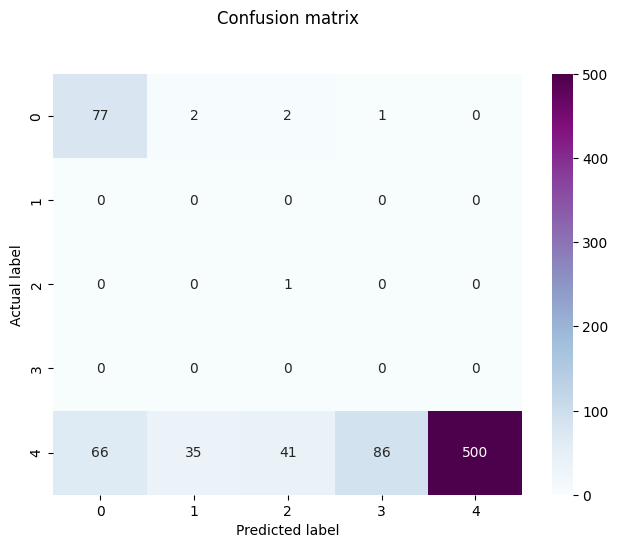

In [63]:
y_pred_bayes_train = pipeline_Bayes.predict(x_train)
evaluation(y_pred_bayes_train, y_train)

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       144
           2       0.97      1.00      0.99        36
           3       1.00      1.00      1.00        44
           4       0.95      1.00      0.98        83
           5       1.00      0.99      1.00       504

    accuracy                           0.99       811
   macro avg       0.99      1.00      0.99       811
weighted avg       0.99      0.99      0.99       811



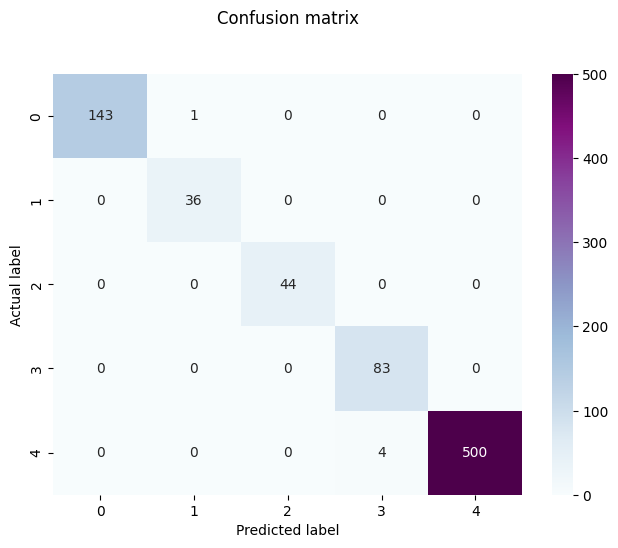

In [64]:
y_pred_rf_train = pipeline_Random.predict(x_train)
evaluation(y_pred_rf_train, y_train)

              precision    recall  f1-score   support

           1       0.85      0.84      0.84       144
           2       0.00      1.00      0.00         0
           3       0.05      1.00      0.09         2
           4       0.13      1.00      0.22        11
           5       0.99      0.76      0.86       654

    accuracy                           0.78       811
   macro avg       0.40      0.92      0.40       811
weighted avg       0.95      0.78      0.85       811



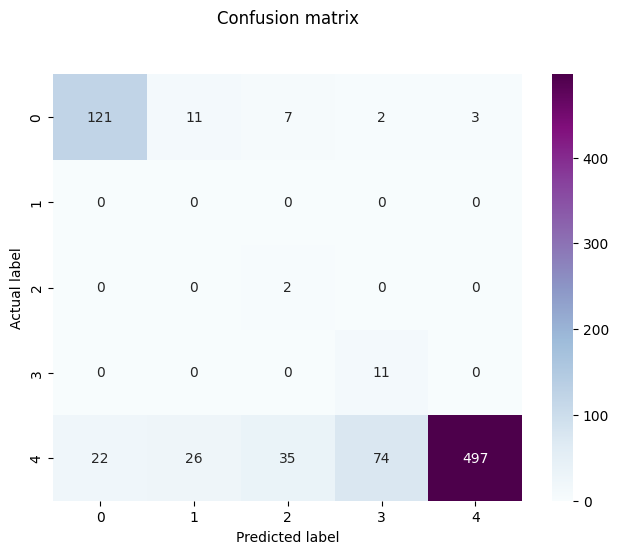

In [65]:
y_pred_lr_train = pipeline_Logistic.predict(x_train)
evaluation(y_pred_lr_train, y_train)

              precision    recall  f1-score   support

           1       0.99      0.95      0.97       148
           2       0.41      1.00      0.58        15
           3       0.48      1.00      0.65        21
           4       0.55      1.00      0.71        48
           5       1.00      0.86      0.93       579

    accuracy                           0.89       811
   macro avg       0.68      0.96      0.77       811
weighted avg       0.95      0.89      0.91       811



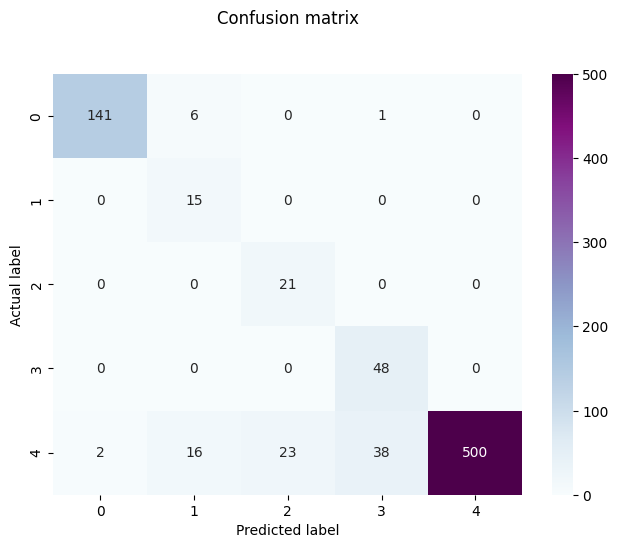

In [66]:
y_pred_svc_train = pipeline_SVC2.predict(x_train)
evaluation(y_pred_svc_train, y_train)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       137
           1       0.89      1.00      0.94        33
           2       0.91      1.00      0.95        40
           3       0.87      0.99      0.93        77
           4       1.00      0.95      0.98       524

    accuracy                           0.97       811
   macro avg       0.93      0.99      0.95       811
weighted avg       0.97      0.97      0.97       811



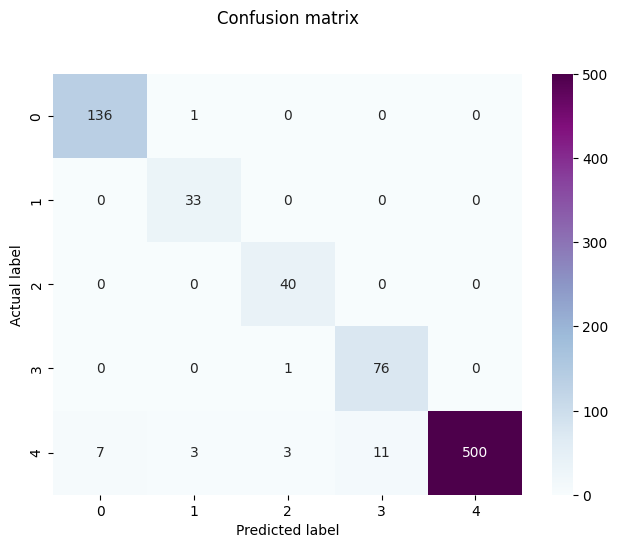

In [67]:
y_pred_xgb_train = pipeline_XGBoost.predict(x_train)
evaluation(y_pred_xgb_train, y_train - 1)

## Evaluation Matrix 2 - Data Validation

### Naive-Bayes

              precision    recall  f1-score   support

           1       0.36      0.71      0.48         7
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.00      1.00      0.00         0
           5       1.00      0.68      0.81        84

    accuracy                           0.68        91
   macro avg       0.27      0.88      0.26        91
weighted avg       0.95      0.68      0.78        91



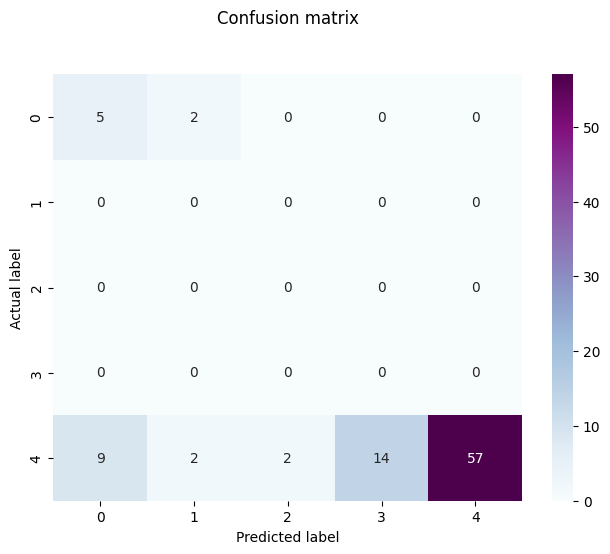

In [68]:
y_pred_bayes = pipeline_Bayes.predict(x_val)
evaluation(y_pred_bayes, y_val)

### Random Forest

              precision    recall  f1-score   support

           1       0.79      0.61      0.69        18
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.07      1.00      0.13         1
           5       0.96      0.76      0.85        72

    accuracy                           0.74        91
   macro avg       0.36      0.88      0.33        91
weighted avg       0.92      0.74      0.81        91



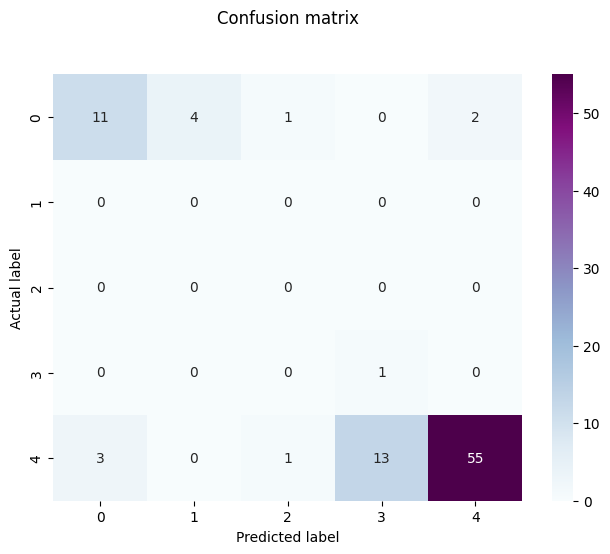

In [69]:
y_pred_rf = pipeline_Random.predict(x_val)
evaluation(y_pred_rf, y_val)

### Logictic Regression

              precision    recall  f1-score   support

           1       0.71      0.62      0.67        16
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.95      0.73      0.82        74

    accuracy                           0.70        91
   macro avg       0.33      0.67      0.30        91
weighted avg       0.90      0.70      0.79        91



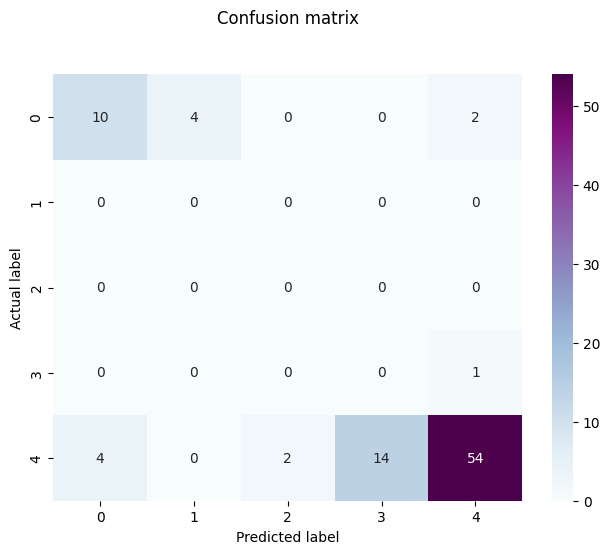

In [70]:
y_pred_lr = pipeline_Logistic.predict(x_val)
evaluation(y_pred_lr, y_val)

### Support Vector Classification (SVC)

              precision    recall  f1-score   support

           1       0.71      0.59      0.65        17
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.00      1.00      0.00         0
           5       0.96      0.74      0.84        74

    accuracy                           0.71        91
   macro avg       0.34      0.87      0.30        91
weighted avg       0.92      0.71      0.80        91



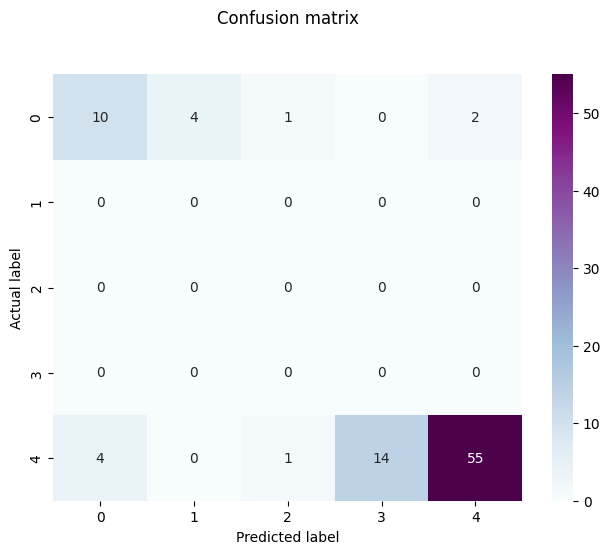

In [71]:
y_pred_svc = pipeline_SVC2.predict(x_val)
evaluation(y_pred_svc, y_val)

### XGBoost

              precision    recall  f1-score   support

           0       0.79      0.61      0.69        18
           1       0.25      1.00      0.40         1
           2       0.00      0.00      0.00         1
           3       0.07      0.25      0.11         4
           4       0.89      0.76      0.82        67

    accuracy                           0.70        91
   macro avg       0.40      0.52      0.40        91
weighted avg       0.82      0.70      0.75        91



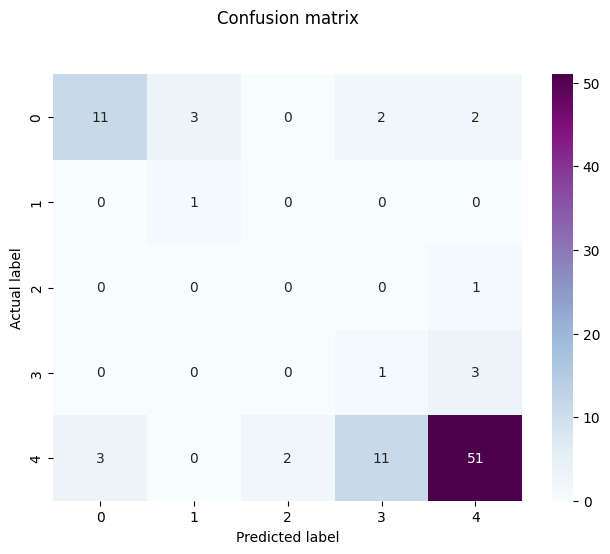

In [72]:
y_pred_xgb = pipeline_XGBoost.predict(x_val)
evaluation(y_pred_xgb, y_val - 1)

Looking at the three models above, the average accuracy is almost the same as SVC (70 %), Random Forest (71 %), Logistic regression (72 %), but for all three the recall value for rating 2 = 0.0

## Hyperparameter Tuning

In [73]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Random Forest

In [74]:
# Number of trees in random forest
n_estimators = np.arange(100, 400, 100)
# Maximum number of levels in tree
max_depth = [10, 20, 30]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]


random_grid = {'classifier__n_estimators': n_estimators,
               'classifier__max_depth': max_depth,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf' : min_samples_leaf,
              }
BestParamsforest= RandomizedSearchCV(pipeline_Random, random_grid, cv=5, n_jobs=-1, verbose=1)
BestParamsforest.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                             ('tfidf', TfidfTransformer()),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'classifier__max_depth': [10, 20, 30],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': array([100, 200, 300])},
                   verbose=1)

              precision    recall  f1-score   support

           1       0.75      0.92      0.83       116
           2       0.41      1.00      0.58        15
           3       0.34      1.00      0.51        15
           4       0.24      1.00      0.39        21
           5       1.00      0.78      0.87       644

    accuracy                           0.81       811
   macro avg       0.55      0.94      0.63       811
weighted avg       0.92      0.81      0.84       811



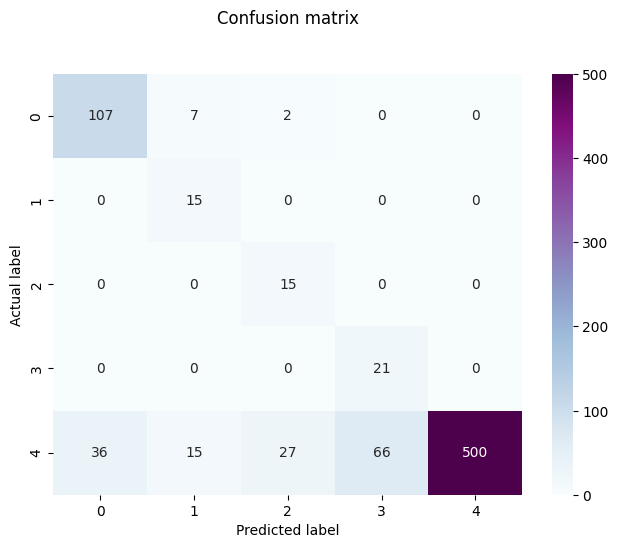

In [75]:
y_pred_rf_max_train = BestParamsforest.predict(x_train)
evaluation(y_pred_rf_max_train, y_train)

              precision    recall  f1-score   support

           1       0.50      0.58      0.54        12
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.00      1.00      0.00         0
           5       0.96      0.70      0.81        79

    accuracy                           0.68        91
   macro avg       0.29      0.86      0.27        91
weighted avg       0.90      0.68      0.77        91



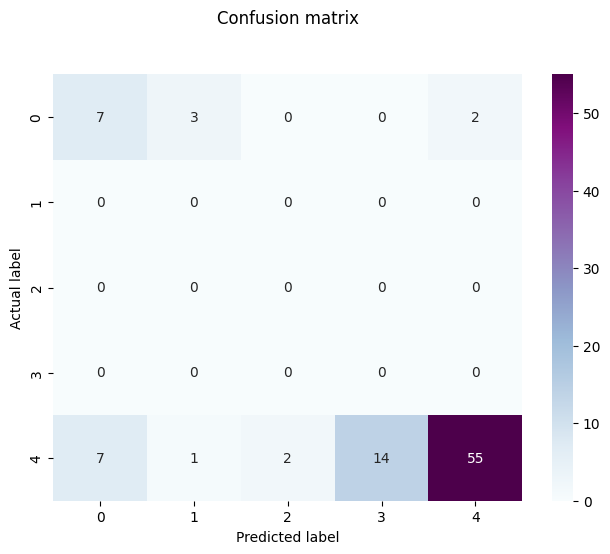

In [76]:
y_pred_rf_max = BestParamsforest.predict(x_val)
evaluation(y_pred_rf_max, y_val)

### Support Vector Classification (SVC)

In [77]:
random_grid = {'classifier__C': [0.1, 1, 10, 100, 1000],
               'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
               'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
BestParamsSVC = RandomizedSearchCV(pipeline_SVC2, random_grid, cv=5, n_jobs= -1, verbose=1)
BestParamsSVC.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                             ('tfidf', TfidfTransformer()),
                                             ('classifier', SVC())]),
                   n_jobs=-1,
                   param_distributions={'classifier__C': [0.1, 1, 10, 100,
                                                          1000],
                                        'classifier__gamma': [1, 0.1, 0.01,
                                                              0.001, 0.0001],
                                        'classifier__kernel': ['linear', 'poly',
                                                               'rbf',
                                                               'sigmoid']},
                   verbose=1)

              precision    recall  f1-score   support

           1       0.31      0.88      0.46        50
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.00      1.00      0.00         0
           5       1.00      0.66      0.79       761

    accuracy                           0.67       811
   macro avg       0.26      0.91      0.25       811
weighted avg       0.96      0.67      0.77       811



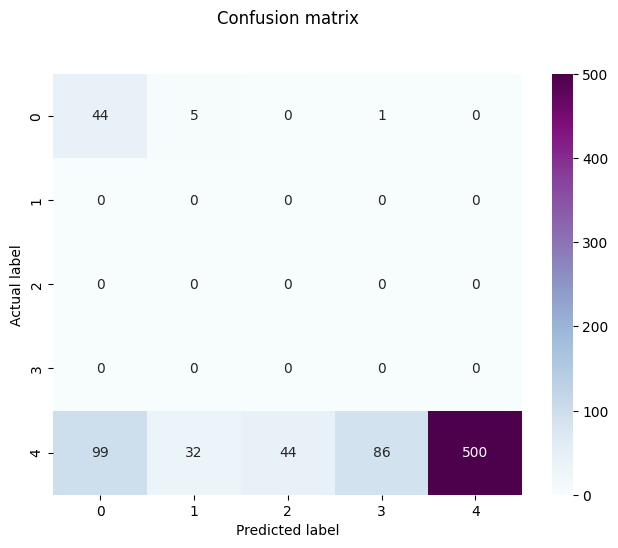

In [78]:
y_pred_svc_max_train = BestParamsSVC.predict(x_train)
evaluation(y_pred_svc_max_train, y_train)

              precision    recall  f1-score   support

           1       0.21      0.43      0.29         7
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.00      1.00      0.00         0
           5       1.00      0.68      0.81        84

    accuracy                           0.66        91
   macro avg       0.24      0.82      0.22        91
weighted avg       0.94      0.66      0.77        91



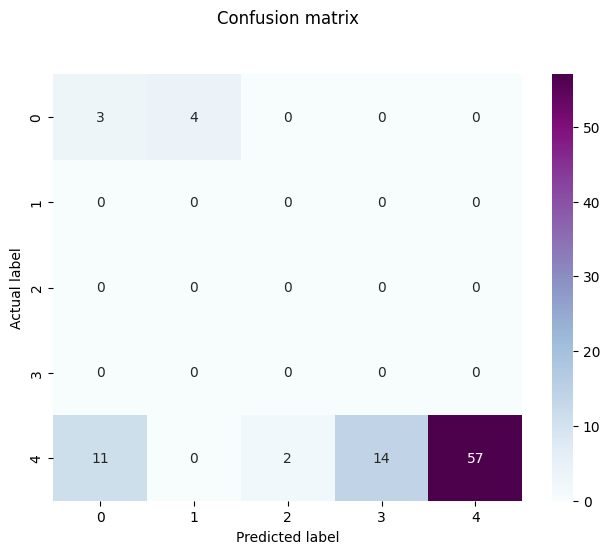

In [79]:
y_pred_svc_max = BestParamsSVC.predict(x_val)
evaluation(y_pred_svc_max, y_val)

### XGBoost

In [80]:
# Define the hyperparameters grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
}

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline_XGBoost, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(x_train, y_train - 1)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__n_estimators': 300}


              precision    recall  f1-score   support

           0       0.81      0.89      0.85       130
           1       0.70      1.00      0.83        26
           2       0.50      1.00      0.67        22
           3       0.49      1.00      0.66        43
           4       1.00      0.84      0.91       590

    accuracy                           0.87       811
   macro avg       0.70      0.95      0.78       811
weighted avg       0.92      0.87      0.88       811



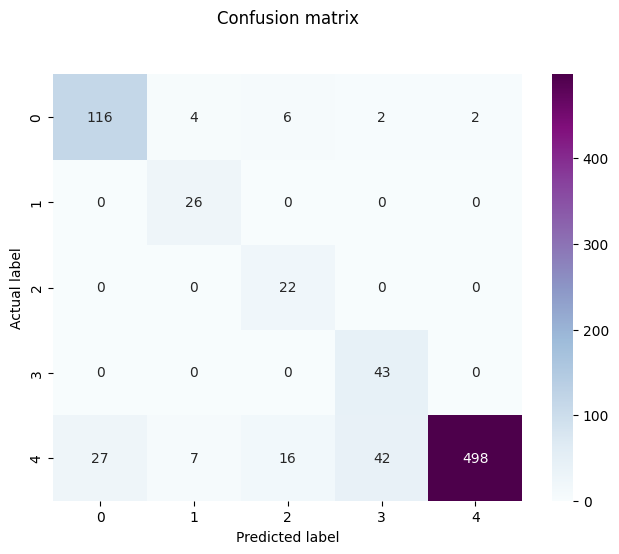

In [81]:
BestParamsXGB = grid_search.best_estimator_
y_pred_xgb_max_train = BestParamsXGB.predict(x_train)
evaluation(y_pred_xgb_max_train, y_train - 1)

              precision    recall  f1-score   support

           0       0.71      0.50      0.59        20
           1       0.00      1.00      0.00         0
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.93      0.75      0.83        71

    accuracy                           0.69        91
   macro avg       0.33      0.85      0.28        91
weighted avg       0.88      0.69      0.78        91



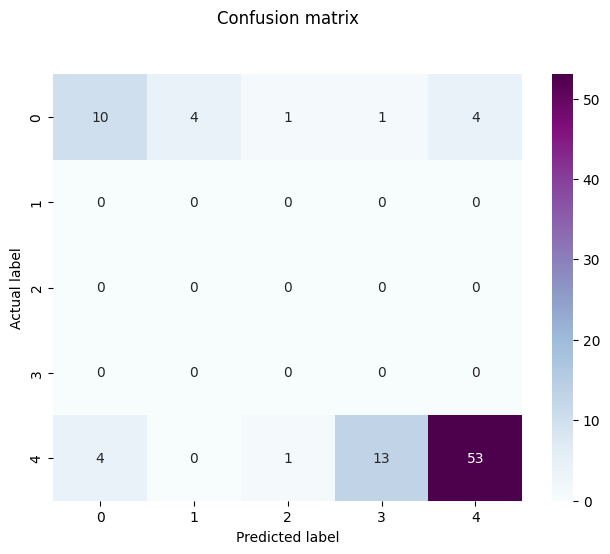

In [82]:
y_pred_xgb_max = BestParamsXGB.predict(x_val)
evaluation(y_pred_xgb_max, y_val - 1)

## Final Processing

In [ ]:
df_test['LABEL'] = BestParamsXGB.predict(df_test['PREPROCESS']) + 1
df_test

In [ ]:
# Create result dataframe
result_df = pd.DataFrame({'ID': df_test['ID'], 'LABEL': df_test['LABEL']})

# Menyimpan dataframe dalam csv
result_df.to_csv('result/final-xgb-best.csv', index=False)

## Recurrent neural network (RNN) - LSTM

In [ ]:
## Get the checkpoint file
df = pd.read_csv('checkpoint/preprocessed-4.csv')
df.head()

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf

tokenizer = Tokenizer(oov_token="unk")
tokenizer.fit_on_texts(df['PREPROCESS'].tolist())

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(df['PREPROCESS'].tolist(), df['LABEL'].tolist(), random_state=42, test_size=0.285714)

In [ ]:
from collections import Counter

def count_unique_and_frequencies(lst):
    # Use Counter to count frequencies
    freq_counter = Counter(lst)
    
    # Print unique numbers and their frequencies
    for num, freq in freq_counter.items():
        print(f"Number {num} has frequency {freq}")
        
count_unique_and_frequencies(y_train)

In [ ]:
count_unique_and_frequencies(y_valid)

In [ ]:
sequences = tokenizer.texts_to_sequences(df['PREPROCESS'].tolist())
max_length = max([len(seq) for seq in sequences])

# Convert texts to sequences
x_train_seq = tokenizer.texts_to_sequences(X_train)
x_valid_seq = tokenizer.texts_to_sequences(X_valid)

# Padding sequences
x_train_pad = pad_sequences(x_train_seq, padding='post', maxlen=max_length)
x_valid_pad = pad_sequences(x_valid_seq, padding='post', maxlen=max_length)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train_pad, np.asarray(tf.keras.utils.to_categorical(y_train))))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid_pad, np.asarray(tf.keras.utils.to_categorical(y_valid))))

In [ ]:
from tensorflow.keras import regularizers
embedding_dim = 64
vocab_size = len(tokenizer.word_index) + 1

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, embeddings_regularizer=regularizers.l2(0.0005)))                                     
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=32, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(6, activation='softmax', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])


In [ ]:
epochs = 5
# Fit the model using the train and test datasets.
history = model.fit(train_ds.shuffle(100).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

In [ ]:
# Get the test checkpoint
df_test = pd.read_csv('checkpoint/test-preprocessed-4.csv')
df_test.head()

In [ ]:
# Convert texts to sequences
x_test_seq = tokenizer.texts_to_sequences(df_test['PREPROCESS'].tolist())

# Padding sequences
x_test_pad = pad_sequences(x_test_seq, padding='post', maxlen=max_length)

In [ ]:
predictions = model.predict(x_test_pad)
predictions_res = predictions.argmax(axis=1)
print(predictions_res)

In [ ]:
predictions_results = pd.DataFrame(df_test['REVIEW'], columns=['REVIEW'])
predictions_results2 = pd.DataFrame(predictions_res, columns=['LABEL'])

predictions_results = pd.concat([predictions_results, predictions_results2], axis=1)
predictions_results

In [ ]:
# Menyimpan dataframe dalam csv
predictions_results.to_csv('result/final-lstm-sofar.csv', index=False)